In [1]:
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
def peek(df):
    display(df.iloc[0:3, :])
    print(len(df))

In [3]:
def repair_dates(df):
    df['date_range_start'] = pd.to_datetime(df['date_range_start'], utc=True)
    df['date_range_start'] = df['date_range_start'].dt.tz_convert('US/Eastern')

In [63]:
def smoothen(df, columns=[], N=6):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns."""
    rolling_avg_df = df.copy()
    # An N-day rolling average with N/2 days before and N/2 after requires N+1
    # days to include the day of as well.
    rolling_avg_df[columns] = (
        rolling_avg_df[columns].rolling(N + 1, center=True).mean())
    return rolling_avg_df

def smoothen_within(df, columns=[], by=None, N=6):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns within each attribute class
    determined by the given "by" attribute."""
    attr_classes = set(df[by])
    rolling_dfs = []
    for attr_class in attr_classes:
        attr_class_df = df[df[by] == attr_class]
        rolling_dfs.append(smoothen(attr_class_df, columns, N=N))
    rolling_df = pd.concat(rolling_dfs)
    rolling_df = rolling_df.sort_values(by=['date_range_start', by])
    return rolling_df

In [8]:
home_weekly_df = pd.read_csv(f'./exports/home_weekly.csv')
repair_dates(home_weekly_df)
home_weekly_df = home_weekly_df[home_weekly_df['date_range_start'].dt.year.isin([2019, 2020])]
home_weekly_df = home_weekly_df.rename(columns={'home_cbg': 'cbg'})
peek(home_weekly_df)

,placekey,date_range_start,cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi
95,22t-222@627-s7m-rtv,2019-01-07 00:00:00-05:00,360050001000,4,0.000000,0.333333,0.000000,0.000000
96,22t-222@627-s7m-rtv,2019-01-07 00:00:00-05:00,360470206001,4,9.790000,0.021739,0.021739,2.772665
97,22t-222@627-s7m-rtv,2019-01-07 00:00:00-05:00,360470435003,4,8.605042,0.016129,0.016129,2.437068


26675352


In [30]:
poi_df = pd.read_csv(f'./exports/poi_health_recategorized.csv')
categories = list(set(poi_df['category']))
peek(poi_df)

,placekey,cbg,naics_code,category,sub_category,location_name,area_square_feet,latitude,longitude
0,226-222@627-s4n-pqf,360610158022,311811,Snacks and Bakeries,Retail Bakeries,Unna Bakery,NaN,40.787027,-73.950435
1,225-225@627-s99-9xq,360810849002,311811,Snacks and Bakeries,Retail Bakeries,Fay Da Bakery,24759.0,40.756244,-73.829009
2,225-225@627-vsw-7nq,360850146071,311811,Snacks and Bakeries,Retail Bakeries,Amici Bakery,16166.0,40.559894,-74.166016


36467


In [17]:
home_total_df = home_df.groupby(by=['date_range_start']).agg({'estimated_visitor_count': 'sum'}).reset_index()
home_total_df = home_total_df.rename(columns={'estimated_visitor_count': 'total_estimated_visitor_count'})
home_total_df = home_total_df.sort_values(by=['date_range_start'])
peek(home_total_df)

,date_range_start,total_estimated_visitor_count
0,2019-01-07 00:00:00-05:00,3.003713e+06
1,2019-01-14 00:00:00-05:00,3.031450e+06
2,2019-01-21 00:00:00-05:00,2.963663e+06


102


In [19]:
home_df = home_weekly_df.merge(poi_df[['placekey', 'category']], on='placekey', how='inner')
home_df = home_df.groupby(by=['date_range_start', 'category']).agg({'estimated_visitor_count': 'sum'}).reset_index()
home_df = home_df.merge(home_total_df, on='date_range_start', how='inner')
home_df['percent'] = home_df['estimated_visitor_count'] / home_df['total_estimated_visitor_count']
peek(home_df)

,date_range_start,category,estimated_visitor_count,total_estimated_visitor_count,percent
0,2019-01-07 00:00:00-05:00,"Beer, Wine, and Liquor Stores",33270.366913,3.003713e+06,0.011076
1,2019-01-07 00:00:00-05:00,Big Box Grocers,55481.302322,3.003713e+06,0.018471
2,2019-01-07 00:00:00-05:00,Delis and Convenience Stores,123625.808571,3.003713e+06,0.041158


1428


In [28]:
# Verify that percentages sum to 100%.
check_df = home_df.groupby(by=['date_range_start']).agg({
    'estimated_visitor_count': 'sum',
    'total_estimated_visitor_count': 'first',
    'percent': 'sum',
})
TOLERANCE = 0.001
print('Weeks not summing to 100%:')
display(len(check_df[check_df['percent'] < 1 - TOLERANCE]))
display(len(check_df[check_df['percent'] > 1 + TOLERANCE]))
peek(check_df)

Weeks not summing to 100%:


0

0

,estimated_visitor_count,total_estimated_visitor_count,percent
date_range_start,,,
2019-01-07 00:00:00-05:00,3.003713e+06,3.003713e+06,1.0
2019-01-14 00:00:00-05:00,3.031450e+06,3.031450e+06,1.0
2019-01-21 00:00:00-05:00,2.963663e+06,2.963663e+06,1.0


102


In [64]:
percent_df = home_df.pivot(index=['date_range_start'], columns=['category'], values=['percent'])
percent_df = smoothen(percent_df, percent_df.columns)
peek(percent_df)

percent                  \
category                  Beer, Wine, and Liquor Stores Big Box Grocers   
date_range_start                                                          
2019-01-07 00:00:00-05:00                           NaN             NaN   
2019-01-14 00:00:00-05:00                           NaN             NaN   
2019-01-21 00:00:00-05:00                           NaN             NaN   

                                                                        \
category                  Delis and Convenience Stores Drinking Places   
date_range_start                                                         
2019-01-07 00:00:00-05:00                          NaN             NaN   
2019-01-14 00:00:00-05:00                          NaN             NaN   
2019-01-21 00:00:00-05:00                          NaN             NaN   

                                                               \
category                  Fast-Food Restaurants Food Services   
date_range_start                                                
2019-01-07 00:00:00-05:00                   NaN           NaN   
2019-01-14 00:00:00-05:00                   NaN           NaN   
2019-01-21 00:00:00-05:00                   NaN           NaN   

                                                                               \
category                  Full-Service Restaurants General Merchandise Stores   
date_range_start                                                                
2019-01-07 00:00:00-05:00                      NaN                        NaN   
2019-01-14 00:00:00-05:00                      NaN                        NaN   
2019-01-21 00:00:00-05:00                      NaN                        NaN   

                                                       \
category                  Limited-Service Restaurants   
date_range_start                                        
2019-01-07 00:00:00-05:00                         NaN   
2019-01-14 00:00:00-05:00                         NaN   
2019-01-21 00:00:00-05:00                         NaN   

                                                                          \
category                  Pharmacies and Drug Stores Snacks and Bakeries   
date_range_start                                                           
2019-01-07 00:00:00-05:00                        NaN                 NaN   
2019-01-14 00:00:00-05:00                        NaN                 NaN   
2019-01-21 00:00:00-05:00                        NaN                 NaN   

                                                                             
category                  Specialty Food Stores Supermarkets Tobacco Stores  
date_range_start                                                             
2019-01-07 00:00:00-05:00                   NaN          NaN            NaN  
2019-01-14 00:00:00-05:00                   NaN          NaN            NaN  
2019-01-21 00:00:00-05:00                   NaN          NaN            NaN

102


In [75]:
def plot_stack(df):
    fig, ax = plt.subplots(2, 1, figsize=(16, 8))

    cmap = plt.cm.get_cmap('tab20')
    colors = [cmap(i / 20) for i in range(0, 20)]

    ax[0].stackplot(df.index, df.transpose(), labels=[c[1] for c in df.columns], colors=colors, alpha=0.8)
    ax[0].axvline(datetime.datetime(2020, 3, 20), linestyle='--', color='#000')
    ax[0].legend(loc='lower left')

    for i, label in enumerate(df.columns):
        ax[1].plot(df.index, df.iloc[:, i], color=colors[i], label=label[1])
    ax[1].axvline(datetime.datetime(2020, 3, 20), linestyle='--', color='#000')
    ax[1].legend(loc='lower left')
    plt.tight_layout()
    plt.show()

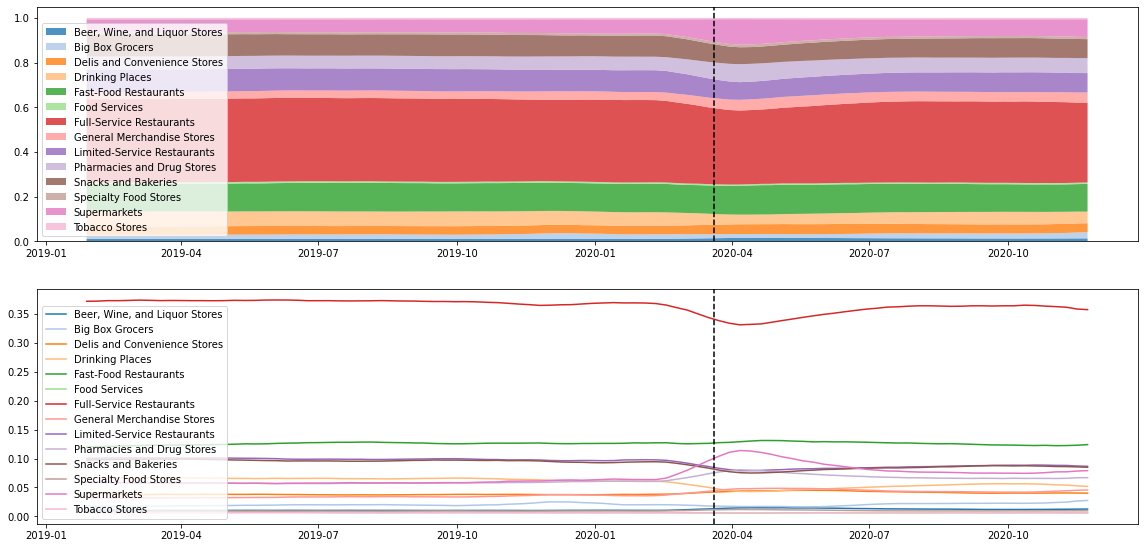

In [76]:
plot_stack(percent_df)